In [119]:
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from PIL import Image
from io import BytesIO

In [120]:
with open("simulated_stroke_data/strokes.npy", "rb") as f:
    strokes = np.load(f)
with open("simulated_stroke_data/trajectories.npy", "rb") as f:
    trajectories = np.load(f)

strokes = torch.from_numpy(strokes).float()
trajectories = torch.from_numpy(trajectories).float()

In [121]:
def visualize_points(points):
    fig, ax = plt.subplots()
    plt.xlim([-0.3, 1])
    plt.ylim([-0.5, 0.5])
    ax.set_aspect('equal', adjustable='box')
    lines = []
    for i, (x,y,z) in enumerate(points):
        ax.add_patch(plt.Circle((x, y), z/20))
        if i != len(points)-1:
            lines.append([(x,y),(points[i+1][0], points[i+1][1])])
            lc = mc.LineCollection(lines, linewidth=0.1, antialiaseds=False)
            ax.add_collection(lc)
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf)
    plt.close()
    return img

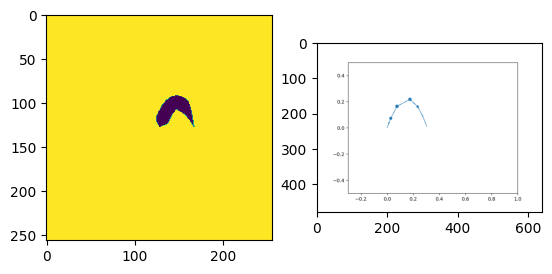

In [136]:
idx = 10
_, axs = plt.subplots(1,2)
axs[0].imshow(strokes[idx])
axs[1].imshow(visualize_points(trajectories[idx]))

In [5]:
from StrokeTrajDataset import StrokeTrajDataset
from SimVAE import SimVAE
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os

resize = torchvision.transforms.Resize((64, 64), antialias=True)
s = resize(strokes)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

model = SimVAE()
model.to(device)
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(s))
from sklearn.utils import shuffle
s, t = shuffle(s, trajectories, random_state=0)
train = s[:train_test_split], t[:train_test_split]
test = s[train_test_split:], t[train_test_split:]

train_dataset = StrokeTrajDataset(*train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = StrokeTrajDataset(*test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def validation(model, dataloader):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for (stroke,trajectory) in dataloader:
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            stroke_dec = args[0][0][i].squeeze(0).cpu().detach().numpy()
            traj_dec = args[0][1][i].cpu().detach().numpy()
            decoder_outputs.append((stroke_dec, traj_dec))
            stroke = args[1][0][i].squeeze(0).cpu().detach().numpy()
            traj = args[1][1][i].cpu().detach().numpy()
            originals.append((stroke, traj))

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

for epoch in range(200):
    total_loss = 0
    for (i, (stroke, trajectory)) in enumerate(train_dataloader):
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%200 == 199:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                stroke_dec = args[0][0][i].squeeze(0).cpu().detach().numpy()
                traj_dec = args[0][1][i].cpu().detach().numpy()
                stroke = args[1][0][i].squeeze(0).cpu().detach().numpy()
                traj = args[1][1][i].cpu().detach().numpy()

                plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
                plt.imsave(f"{output_dir}/{i}-original.png", stroke)
                visualize_points(traj_dec).save(f"{output_dir}/{i}-traj_decoded.png")
                visualize_points(traj).save(f"{output_dir}/{i}-traj_original.png")
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader)

    if epoch%200 == 199:
        output_dir = f"training_outputs/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(decoded_list)):
            stroke_dec, traj_dec = decoded_list[i][0], decoded_list[i][1]
            stroke, traj = original_list[i][0], original_list[i][1]
            plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
            plt.imsave(f"{output_dir}/{i}-original.png", stroke)
            visualize_points(traj_dec).save(f"{output_dir}/{i}-traj_decoded.png")
            visualize_points(traj).save(f"{output_dir}/{i}-traj_original.png")
    print(f"Epoch {epoch}: Train loss={train_loss}, Validation loss={val_loss}")

Epoch 0: Train loss=1.4887709617614746, Validation loss=1.2704321146011353
Epoch 1: Train loss=0.4749855101108551, Validation loss=0.34217506647109985
Epoch 2: Train loss=0.15081746876239777, Validation loss=0.09936236590147018
Epoch 3: Train loss=0.07314472645521164, Validation loss=0.06049728021025658
Epoch 4: Train loss=0.053144194185733795, Validation loss=0.047462254762649536
Epoch 5: Train loss=0.04516565427184105, Validation loss=0.042315054684877396
Epoch 6: Train loss=0.040938012301921844, Validation loss=0.03940866142511368
Epoch 7: Train loss=0.037217363715171814, Validation loss=0.03628519922494888
Epoch 8: Train loss=0.034860409796237946, Validation loss=0.03257165104150772
Epoch 9: Train loss=0.032982390373945236, Validation loss=0.03376416489481926
Epoch 10: Train loss=0.03158600255846977, Validation loss=0.03068106435239315
Epoch 11: Train loss=0.02941000834107399, Validation loss=0.028502289205789566
Epoch 12: Train loss=0.02822575904428959, Validation loss=0.027913680

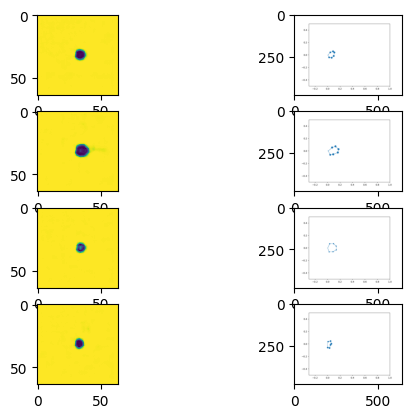

In [6]:
s, t = model.sample_latent(4)
_, axs = plt.subplots(4, 2)
for i in range(4):
    axs[i][0].imshow(s[i].squeeze(0).cpu().detach().numpy())
    axs[i][1].imshow(visualize_points(t[i].cpu().detach().numpy()))

In [146]:
def no_gap_plot(data): # https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots
    # data: N x M x individual image
    N = len(data)
    M = len(data[0])
    heights = [50 for a in data]
    widths = [50 for a in data[0]]
    
    fig_width = 8.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(N,M, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

    for i in range(N):
        for j in range(M):
            axarr[i, j].imshow(data[i][j])
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

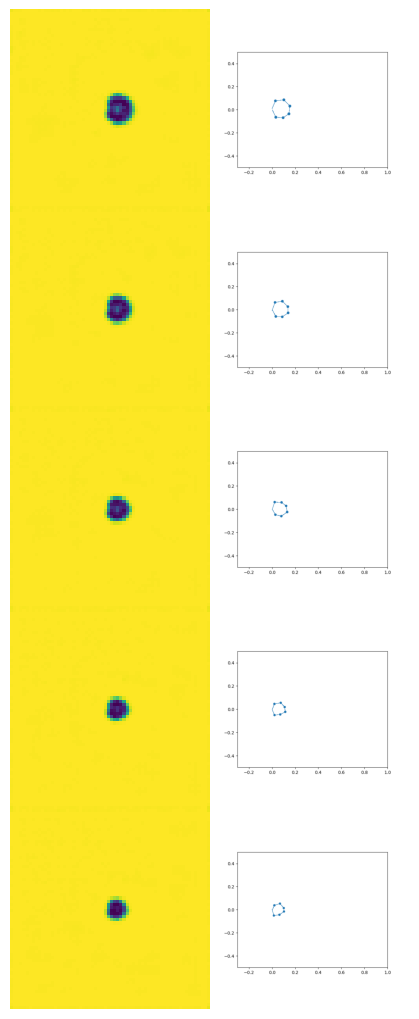

In [100]:
# Interpolating between strokes
def interpolate(idx0, idx1):
    s = resize(strokes)
    t = trajectories
    s0 = s[idx0].unsqueeze(0).unsqueeze(0).to(device)
    t0 = t[idx0].unsqueeze(0).to(device)
    s1 = s[idx1].unsqueeze(0).unsqueeze(0).to(device)
    t1 = t[idx1].unsqueeze(0).to(device)
    enc0, _ = model.encode(s0, t0)
    enc1, _ = model.encode(s1, t1)
    
    num_images = 5
    data = []
    for i in range(num_images):
        t = i / (num_images - 1)
        enc = enc0*(1-t) + enc1*t
        stroke, trajectory = model.decode(enc)
        stroke = stroke.cpu().detach().reshape((64, 64))
        trajectory = visualize_points(trajectory.cpu().detach().squeeze(0))
        data.append([stroke, trajectory])
    no_gap_plot(data)

interpolate(259, 202)

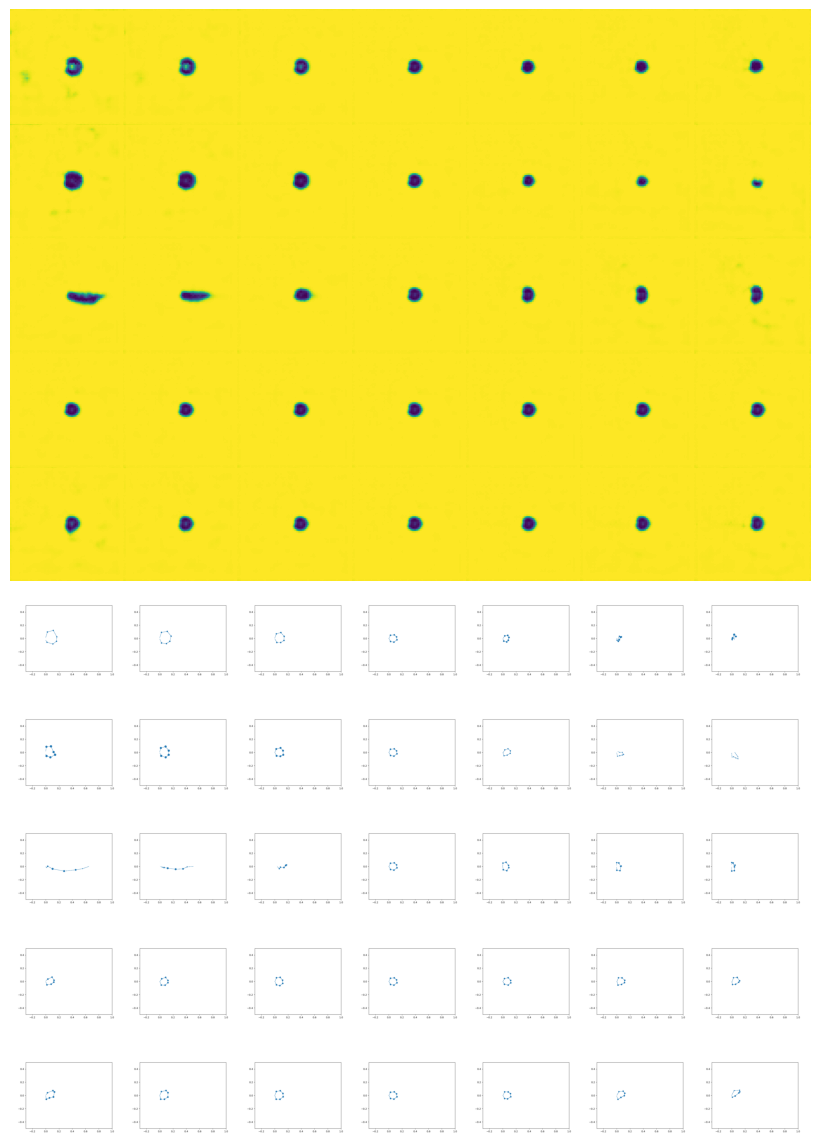

In [151]:
# Varying different latent variables at a time
def vary_one_at_a_time(idx):
    rs = resize(strokes)
    s = rs[idx].unsqueeze(0).unsqueeze(0).to(device)
    t = trajectories[idx].unsqueeze(0).to(device)
    enc, _ = model.encode(s, t)
    s_data = []
    t_data = []
    for i in range(5):
        s_data_row = []
        t_data_row = []
        for j in range(-3, 4):
            shift = torch.zeros(5)
            shift[i] += j
            shift = shift.to(device)
            shifted = enc + shift
            stroke, trajectory = model.decode(shifted)
            stroke = stroke.cpu().detach().reshape((64, 64))
            trajectory = visualize_points(trajectory.cpu().detach().squeeze(0))
            s_data_row.append(stroke)
            t_data_row.append(trajectory)
        s_data.append(s_data_row)
        t_data.append(t_data_row)
    data = s_data + t_data
    no_gap_plot(data)
vary_one_at_a_time(202)